# Final Project

This is the final project for Data 102 at the University of California, Berkeley. This project was to conduct a guided analysis for the dataset of our choice, selected from 3 major topics (or data of your choice). We chose to work with the transportation data set, as well as the New York Times 'Rolling Averages - US Counties' dataset given on Piazza. 

### Collaboration Policy

We believe that data science is a collaborative activity. This project was done jointly by Zoe Parcells, Jillian Criscuolo, Noah Prozan, and Eliza Page van Hamel Platerink.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
import numpy.random as rnd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1 Data Overview

## 1.1 2020-21 US Region Mobility Report and US-counties

The *2020-21 US Region Mobility Report* dataset we used was provided by Google collected through Google Maps. The data shows how traffic en route to specific, categorized places changed compared to prior to the pandemic, with a baseline pre-pandemic day being represented by the median value of the 5‑week period Jan 3 – Feb 6, 2020. It is significant to note that these dates were an extraordinary time for the US economy, meaning increased retail and workplace movement, and may not be entirely representative of all mobility before the pandemic (i.e, the baseline may look different if a five week period from June-July 2019 was used). Each row represents movement trends compared to the determined "baseline" across different categories of places for a sub-region of the United States on a single day. 

We decided to merge this dataset on date, sub-region 1, sub-region 2 with the  *Rolling Averages US Counties dataset* that was provided by the New York Times. By incorporating this dataset, we were able to access the daily number of new cases and deaths, the seven-day rolling average, and the seven-day rolling average per 100,000 residents for each state. The sample of data is drawn from New York Times journalists using county, state, and national government sources to compile these average cases and deaths. Each row represents a different county with totals of how many cases, deaths, and averages of cases and deaths per 100,000 residents were recorded there each day. 

Moreover, the data from the *2020-21 US Region Mobility Report* is drawn from a sample of the population of drivers on the road. Google Map users are aware that their location data was being used as only sets of data from users who have turned on the Location History setting were included. This setting is off by default, meaning that consent is insured but also that a large sector of the population (non-users and users with their Location History setting off) were not accounted for. This creates a relevant concern for convenience sampling as well as selection bias as only those with smartphones that can host Google Maps are represented, systematically excluding those without access to technology. This is important to note when looking at the results of this report as essential workers in the height of the pandemic primarily came from low-income communities who may have not have had access to Google Maps and therefore are not accounted for in the data.

In terms of features/columns that would have been helpful, had they been available in this dataset, are vaccine information and percent of the population that was tested. How many vaccines per state have been administered as well as how many people were getting tested for Covid in each state would have been helpful as these are two potentially confounding variables. This information would have provided additional insight into what factors contributed to how mobility was affected during the pandemic.

In [ ]:
#Importing the regional data for 2020 and 2021
regional_stats_2020 = pd.read_csv('2020_US_Region_Mobility_Report.csv')
regional_stats_2021 = pd.read_csv('2021_US_Region_Mobility_Report.csv')

#Insuring the dates are consistent for merging purposes. 
regional_stats_2021['date'] = pd.to_datetime(regional_stats_2021['date']).dt.strftime("%m/%d/%y")

#Creating a dataset of both years
frames = [regional_stats_2020, regional_stats_2021]
mobility = pd.concat(frames)

#Insuring the counties are consistent for merging purposes. 
mobility['sub_region_2'] = mobility['sub_region_2'].str.replace(" County", "")

#Allowing for easy division by year later down the line
mobility['year'] = pd.DatetimeIndex(mobility['date']).year
mobility

FileNotFoundError: ignored

In [ ]:
#Importing the US County Data
us_counties = pd.read_csv('us-counties.csv')
us_counties['date'] = pd.to_datetime(us_counties['date']).dt.strftime("%m/%d/%y")
us_counties

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,01/21/20,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,01/22/20,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,01/23/20,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,01/24/20,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,01/24/20,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1293953,05/05/21,USA-69120,Tinian,Northern Mariana Islands,0,0.00,0.00,0,0.0,0.0
1293954,05/05/21,USA-69110,Saipan,Northern Mariana Islands,0,0.57,1.19,0,0.0,0.0
1293955,05/05/21,USA-78030,St. Thomas,Virgin Islands,0,6.86,13.28,0,0.0,0.0
1293956,05/05/21,USA-78020,St. John,Virgin Islands,0,0.29,6.85,0,0.0,0.0


In [ ]:
#Merging the data sets by date, state, and county.
regional_stats = pd.merge(mobility, us_counties,  how='left', left_on= ['date', 'sub_region_1', 'sub_region_2'], right_on = ['date', 'state', 'county'])
regional_stats_2021 = regional_stats[regional_stats['year'] == 2021]
regional_stats 

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,...,year,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2/15/20,6.0,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2/16/20,7.0,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2/17/20,6.0,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2/18/20,0.0,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2/19/20,2.0,...,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129552,US,United States,Wyoming,Weston,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,04/26/21,NaN,...,2021,USA-56045,Weston,Wyoming,0.0,0.14,2.06,0.0,0.0,0.0
1129553,US,United States,Wyoming,Weston,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,04/27/21,NaN,...,2021,USA-56045,Weston,Wyoming,0.0,0.14,2.06,0.0,0.0,0.0
1129554,US,United States,Wyoming,Weston,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,04/28/21,NaN,...,2021,USA-56045,Weston,Wyoming,1.0,0.29,4.12,0.0,0.0,0.0
1129555,US,United States,Wyoming,Weston,NaN,NaN,56045.0,ChIJd4Rqhed3YocR7ubT5-HgoJg,04/29/21,NaN,...,2021,USA-56045,Weston,Wyoming,1.0,0.43,6.19,0.0,0.0,0.0


# 2 EDA

We start with cleaning our data! 

After some investigation, we quickly realized that we were not going to need all of the columns, or that they were not going to be exceptionally helpful. We dropped these columns accordingly. We also realized that there were places in the data set where we needed to remove NAN values, specifically in the place where there was no *sub_region_1*, or state label. We did this in order to ensure that we were accurately analyzing the relationship between different states, as our question entails. Removing these values allows for this discussion and deep dive into the difference in mask mandates/COVID restrictions to ensue. 

The decision to remove the columns will not influence our analysis later down the line because they were not related to the questions we were trying to answer. In terms of the NAN values, these were not influential to the analysis because the NAN values mainly occurred in the earliest stages of the pandemic, or even the pre-pandemic stages. This means that the NAN values were before anything was really understood about restrictions or even COVID-19 in general.  

We also split the data into different subgroups by state in order to allow for further discussion about the restrictions. The information about high vs low covid restrictions was taken from [the AARP website](https://www.aarp.org/health/healthy-living/info-2020/states-mask-mandates-coronavirus.html) about the statewide mask mandates in each state. There are 25 states who either never had a statewide mask mandate, or have removed the mask mandate. There are 25 states with high restrictions, who still have a state-wide mask mandate in place. 

We finally created a smaller data set that consists of two states with two relatively high COVID restrictions (California and New York), and two states with relatively low COVID restrictions (Alabama and Texas). We did this for mainly visual purposes. 

In [ ]:
#Define a function to help us drop unneccessary columns from a data set

def drop(lst, data):
    '''
    Args:
        lst (list-like): names of columns to drop
        data (data frame): data frame from which to drop 
        
    Returns:
    The data frame, but with the columns we wanted dropped, dropped. 
    '''
    for c in np.arange(len(lst)):
        data = data.drop(lst[c], axis = 1)
        
    return data

#The column labels we will be dropping from regional_stats
dropping = ['country_region_code', 'country_region','sub_region_2', 'metro_area',
            'iso_3166_2_code', 'census_fips_code', 'place_id', 'geoid', 'county', 'state']

We first did a cleaning on the data from 2020-2021. 

In [ ]:
#Starting the cleaning process dropping columns we do not need
c_regional_stats = drop(dropping, regional_stats)

#Create a column that allows us to plot dates since Jan 1, 2020
c_regional_stats['ddate'] = pd.to_datetime(c_regional_stats['date'])  
c_regional_stats['ddate']= (c_regional_stats['ddate'] - c_regional_stats['ddate'].min())  / np.timedelta64(1,'D')

#Removal of non-existent state levels
c_regional_stats = c_regional_stats[c_regional_stats['sub_region_1'].notna()]

#Create Specific State data sets in order to investigate further into the relationship between different state policies
states_released = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Lousiana', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'New Hampsire', 'North Dakota', 'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Wisconsin', 'Wyoming']
high_vs_low = c_regional_stats.loc[c_regional_stats['sub_region_1'].isin(['California', 'Alabama', 'New York', 'Texas'])]

We then did a cleaning on the data from just 2021

In [ ]:
#Starting the cleaning process dropping columns we do not need
c_regional_stats_2021 = drop(dropping, regional_stats_2021)

#Create a column that allows us to plot dates since Jan 1, 2020
c_regional_stats_2021['ddate'] = pd.to_datetime(c_regional_stats_2021['date'])  
c_regional_stats_2021['ddate']= (c_regional_stats_2021['ddate'] - c_regional_stats_2021['ddate'].min())  / np.timedelta64(1,'D')

#Removal of non-existent state levels
c_regional_stats_2021 = c_regional_stats_2021[c_regional_stats_2021['sub_region_1'].notna()]

#Create Specific State data sets in order to investigate further into the relationship between different state policies
released_mask_mandate_2021 = c_regional_stats_2021.loc[c_regional_stats_2021['sub_region_1'].isin(states_released)]
high_vs_low_2021 = c_regional_stats_2021.loc[c_regional_stats_2021['sub_region_1'].isin(['California', 'Alabama', 'New York', 'Texas'])]

### Causal Inference Cleaning

We also created a dataset where we dropped the NAN values for the Retail column, as well as the covid_avg and deaths_avg columns. We did this in order to ensure a successful Causal Inference later in the notebook. The removal of the NAN values was reasonable, especially for the covid_avg column and for the deaths_avg column, because in the early stages of the pandemic or even pre-pandemic, states and counties were not reporting this data. In some cases this data was not even existent, as COVID-19 was non-existent in these places. 

In [ ]:
#Creates a treatment column
c_regional_stats['treatment'] = np.isin(c_regional_stats['sub_region_1'], states_released)
c_regional_stats_2021['treatment'] = np.isin(c_regional_stats_2021['sub_region_1'], states_released)

causal_data = c_regional_stats[c_regional_stats['cases_avg'].notnull()]
causal_data = causal_data[causal_data['deaths_avg'].notnull()]
causal_data = causal_data[causal_data['retail_and_recreation_percent_change_from_baseline'].notnull()]
causal_data

,sub_region_1,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k,ddate,treatment
874,Alabama,10/10/20,-16.0,-7.0,NaN,NaN,-17.0,6.0,2020,16.0,11.43,20.46,0.0,0.14,0.26,238.0,True
875,Alabama,10/11/20,-8.0,-3.0,-24.0,NaN,-18.0,4.0,2020,7.0,11.00,19.69,0.0,0.14,0.26,239.0,True
876,Alabama,10/12/20,-3.0,2.0,NaN,NaN,-33.0,7.0,2020,6.0,11.43,20.46,0.0,0.14,0.26,240.0,True
877,Alabama,10/13/20,-6.0,0.0,NaN,NaN,-22.0,5.0,2020,13.0,12.14,21.73,0.0,0.14,0.26,241.0,True
878,Alabama,10/14/20,-3.0,6.0,NaN,NaN,-20.0,5.0,2020,4.0,10.86,19.43,0.0,0.14,0.26,242.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129379,Wyoming,04/27/21,9.0,NaN,NaN,41.0,-9.0,3.0,2021,8.0,3.17,15.66,0.0,0.00,0.00,437.0,True
1129380,Wyoming,04/28/21,16.0,NaN,NaN,24.0,-9.0,1.0,2021,7.0,3.71,18.36,0.0,0.00,0.00,438.0,True
1129381,Wyoming,04/29/21,16.0,NaN,NaN,36.0,-11.0,1.0,2021,1.0,3.43,16.95,0.0,0.00,0.00,439.0,True
1129382,Wyoming,04/30/21,18.0,NaN,NaN,59.0,-9.0,1.0,2021,2.0,3.57,17.66,0.0,0.00,0.00,440.0,True


### GLM Cleaning

We also created a dataset where we dropped the NAN values for the Retail column, as well as the ddate (number of days since january 1, 2021)] column. We did this in order to ensure a successful GLM predictions later in the notebook. The removal of the NAN values was reasonable and necessary in order to have a successful GLM prediction 

MUST ADD MORE 

In [ ]:
released_mask_mandate = c_regional_stats_2021.loc[c_regional_stats_2021['sub_region_1'].isin(states_released)]
released_mask_mandate = released_mask_mandate[released_mask_mandate['ddate'].notnull()]
released_mask_mandate = released_mask_mandate[released_mask_mandate['retail_and_recreation_percent_change_from_baseline'].notnull()]

has_mask_mandate = c_regional_stats_2021.loc[~c_regional_stats_2021['sub_region_1'].isin(states_released)]
has_mask_mandate = has_mask_mandate[has_mask_mandate['ddate'].notnull()]
has_mask_mandate = has_mask_mandate[has_mask_mandate['retail_and_recreation_percent_change_from_baseline'].notnull()]



# released_mask_mandate = released_mask_mandate.drop(1104882)

## 2.1 Changes from Baseline by State

We first wanted to see the general trends in percent change from baseline by state. For each listed category (retail/recreation, parks, etc.) we grouped the available data by state, ultimately plotting the mean percent change from baseline for the years 2020 and 2021, respectively.

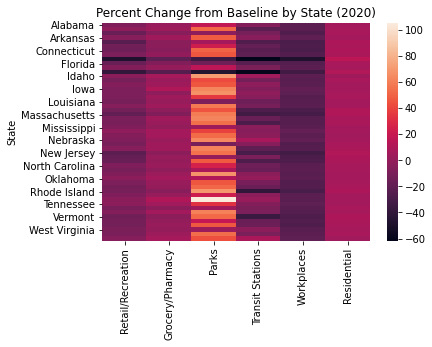

In [ ]:
heatmap_2020 = pd.read_csv('2020_US_Region_Mobility_Report.csv')
heatmap_2020['date'] = pd.to_datetime(heatmap_2020['date'])
US_mobility_2020 = heatmap_2020[heatmap_2020['date'].dt.year == 2020]
US_mobility_2020_state = US_mobility_2020.groupby("sub_region_1").mean()
US_mobility_2020_state.pop('metro_area')
US_mobility_2020_state.pop('census_fips_code')
US_mobility_2020_state = US_mobility_2020_state.rename(columns={"sub_region_1": "State", 
                                                                "retail_and_recreation_percent_change_from_baseline": "Retail/Recreation", 
                                                                "grocery_and_pharmacy_percent_change_from_baseline": "Grocery/Pharmacy", 
                                                                "parks_percent_change_from_baseline": "Parks", 
                                                                "transit_stations_percent_change_from_baseline": "Transit Stations", 
                                                                "workplaces_percent_change_from_baseline": "Workplaces", 
                                                                "residential_percent_change_from_baseline": "Residential"})

ax = plt.axes()
sns.heatmap(US_mobility_2020_state, ax = ax)
ax.set_title('Percent Change from Baseline by State (2020)')
plt.ylabel('State')
plt.show();

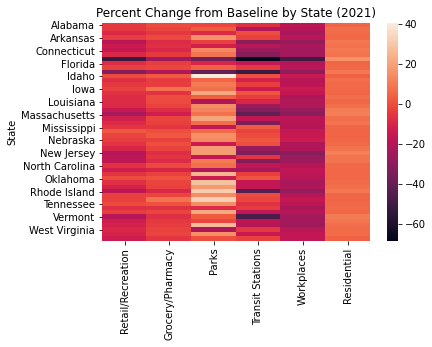

In [ ]:
heatmap_2021 = pd.read_csv('2021_US_Region_Mobility_Report.csv')
heatmap_2021['date'] = pd.to_datetime(heatmap_2021['date'])
US_mobility_2021 = heatmap_2021[heatmap_2021['date'].dt.year == 2021]
US_mobility_2021_state = US_mobility_2021.groupby("sub_region_1").mean()
US_mobility_2021_state.pop('metro_area')
US_mobility_2021_state.pop('census_fips_code')
US_mobility_2021_state = US_mobility_2021_state.rename(columns={"sub_region_1": "State", 
                                                                "retail_and_recreation_percent_change_from_baseline": "Retail/Recreation", 
                                                                "grocery_and_pharmacy_percent_change_from_baseline": "Grocery/Pharmacy", 
                                                                "parks_percent_change_from_baseline": "Parks", 
                                                                "transit_stations_percent_change_from_baseline": "Transit Stations", 
                                                                "workplaces_percent_change_from_baseline": "Workplaces", 
                                                                "residential_percent_change_from_baseline": "Residential"})
ax = plt.axes()
sns.heatmap(US_mobility_2021_state, ax = ax)
ax.set_title('Percent Change from Baseline by State (2021)')
plt.ylabel('State')
plt.show();

## 2.2 Transit Percent Changes

Based on the two heatmaps, it is clear that states that have a there is a significant different in transit between states. We wanted to analyze the difference in two states that had particularly high covid restrictions (CA and NY) and two states that had typically low covid restrictions (AL and TX).

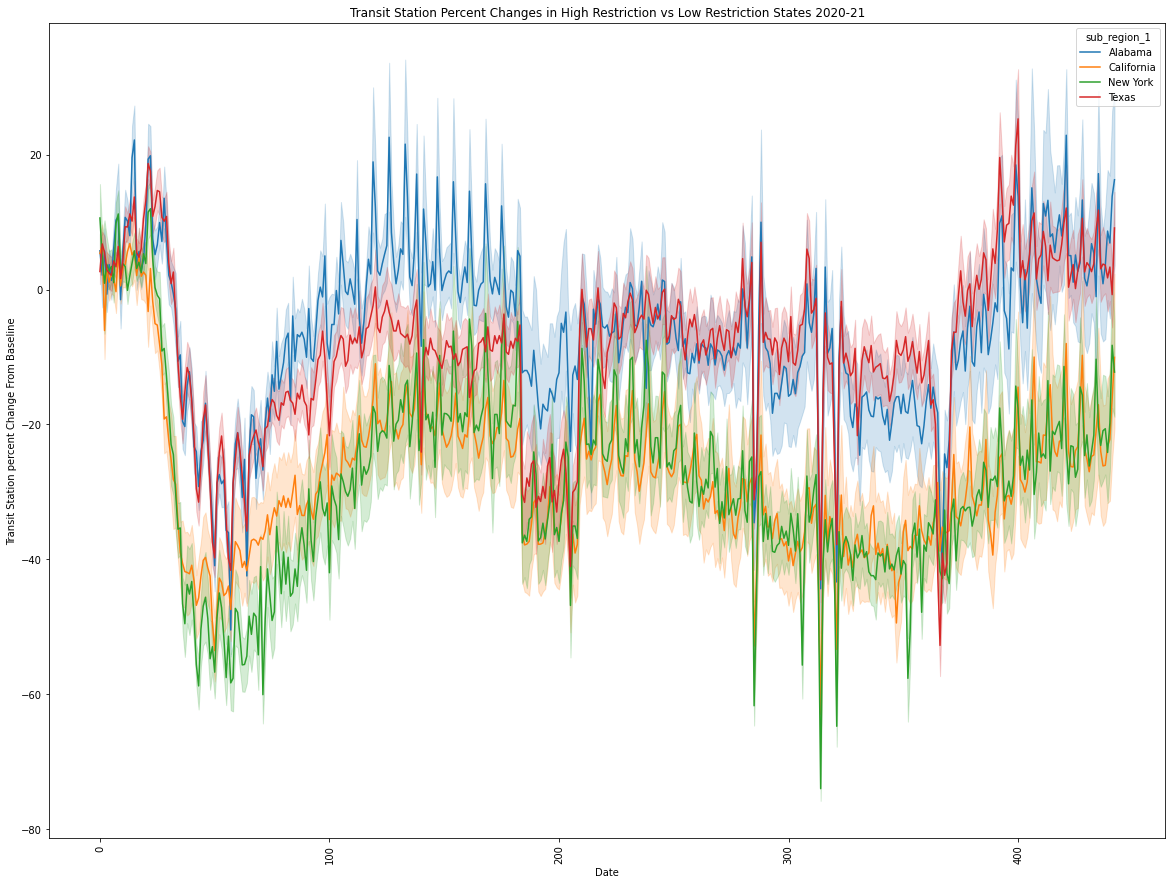

In [ ]:
sns.lineplot(x="ddate", y="transit_stations_percent_change_from_baseline", hue="sub_region_1", data=high_vs_low)
plt.gcf().set_size_inches(20, 15)
plt.ylabel("Transit Station percent Change From Baseline")
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.title("Transit Station Percent Changes in High Restriction vs Low Restriction States 2020-21")
plt.show();

Texas removed the mask mandate on March 10 (68 days after January 1)
Alabama removed the mask mandate on April 9 (98 days after January 1)

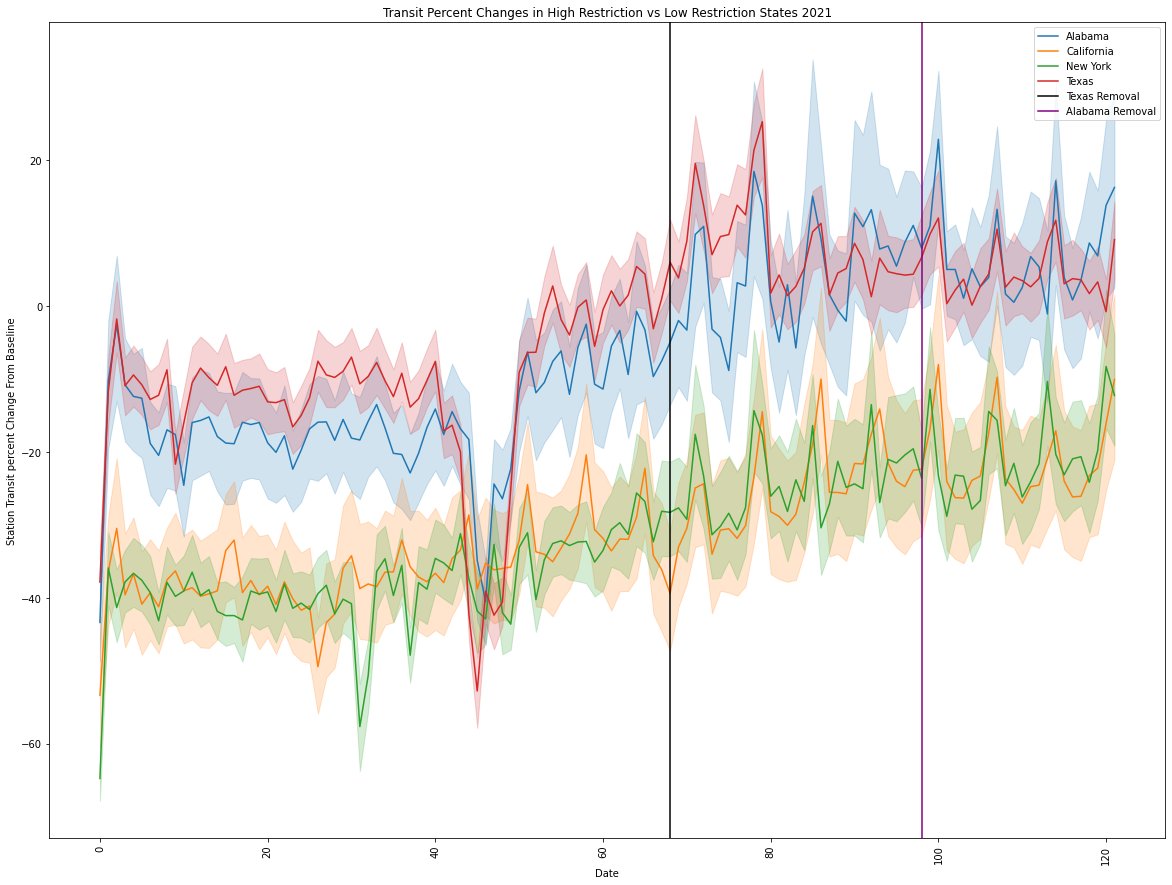

In [ ]:
sns.lineplot(x="ddate", y="transit_stations_percent_change_from_baseline", hue="sub_region_1", data=high_vs_low_2021)
plt.gcf().set_size_inches(20, 15)
plt.ylabel("Station Transit percent Change From Baseline")
plt.xticks(rotation = 90)
plt.xlabel("Date")

plt.axvline(x=68, label = "Texas Removal", color = 'black')
plt.axvline(x=98, label = "Alabama Removal", color = 'purple')

plt.title("Transit Percent Changes in High Restriction vs Low Restriction States 2021")
plt.legend()
plt.show();

From the two graphs above, we can see a clear grouping between the states with high covid restrictions and their transit percent change, and th states with low covid restrictions and their transit percent change. We hope to do some investigation into why this happens!

## 2.3 Retail and Recreation Percent Changes

Similarly to transit, we decided to explore retail and recreation further after seeing significant variance between different states. 

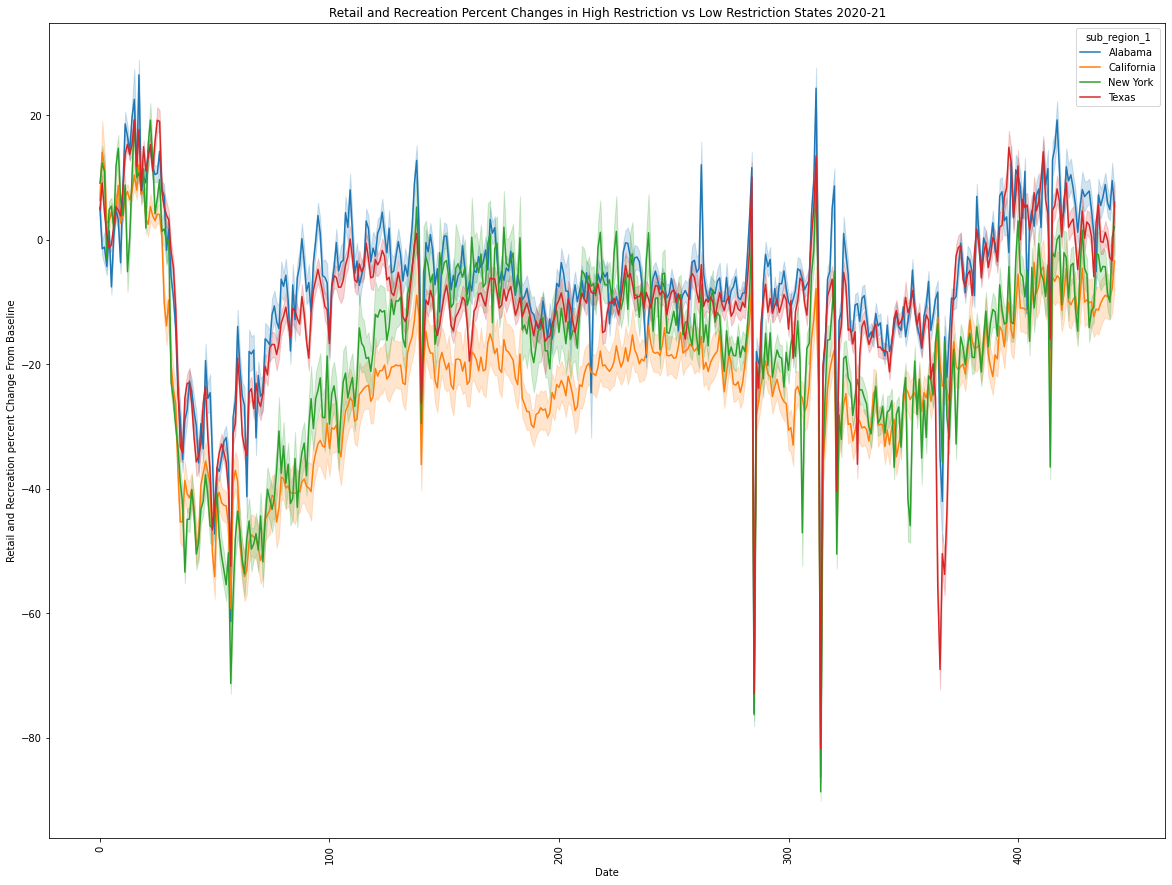

In [ ]:
sns.lineplot(x="ddate", y="retail_and_recreation_percent_change_from_baseline", hue="sub_region_1", data=high_vs_low)
plt.gcf().set_size_inches(20, 15)
plt.ylabel("Retail and Recreation percent Change From Baseline")
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.title("Retail and Recreation Percent Changes in High Restriction vs Low Restriction States 2020-21")
plt.show();

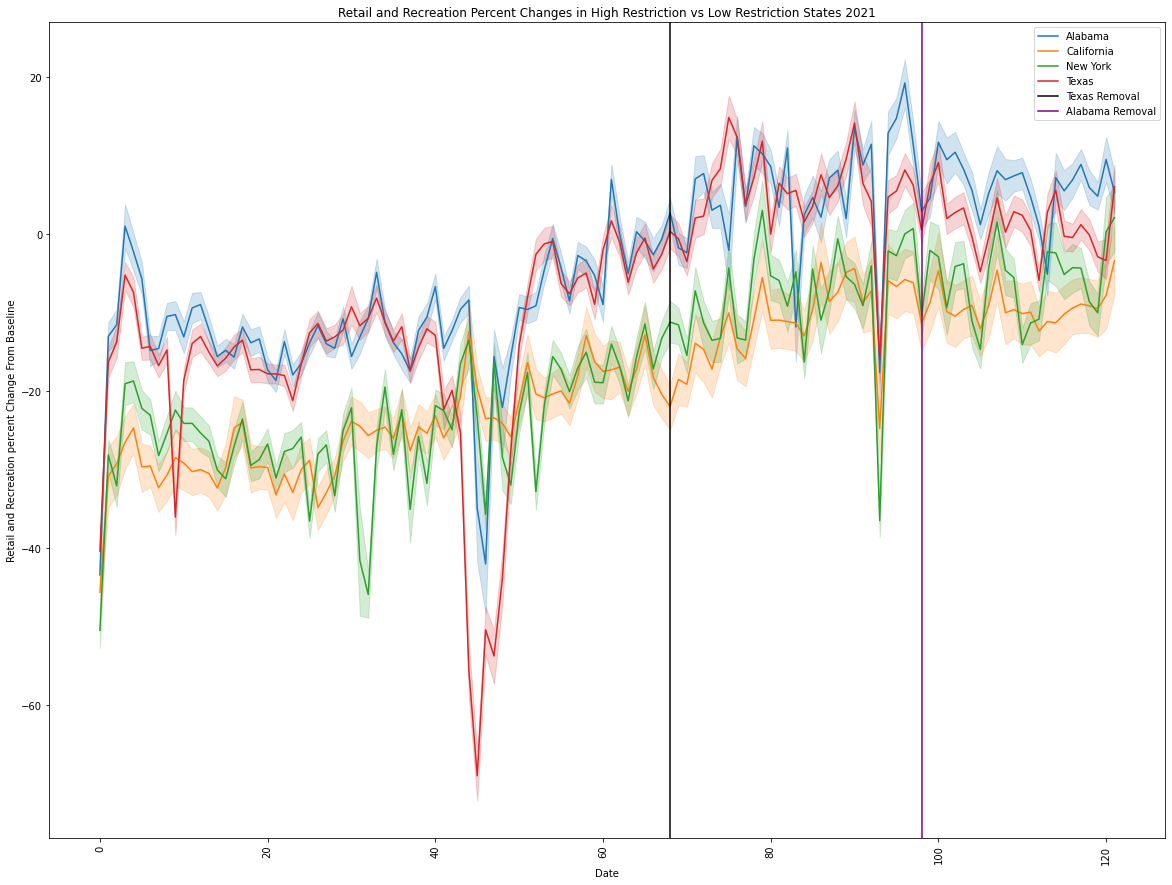

In [ ]:
sns.lineplot(x="ddate", y="retail_and_recreation_percent_change_from_baseline", hue="sub_region_1", data=high_vs_low_2021)
plt.gcf().set_size_inches(20, 15)
plt.ylabel("Retail and Recreation percent Change From Baseline")
plt.xticks(rotation = 90)
plt.xlabel("Date")

plt.axvline(x=68, label = "Texas Removal", color = 'black')
plt.axvline(x=98, label = "Alabama Removal", color = 'purple')


plt.title("Retail and Recreation Percent Changes in High Restriction vs Low Restriction States 2021")
plt.legend()
plt.show();

From the two graphs above, we can see a clear grouping between the states with high covid restrictions and their retail and recreation percent change, and th states with low covid restrictions and their retail and recreation percent change. We hope to do some investigation into why this happens!

# 3 Research Questions

## 3.1 Question 1
The first question we seek to address is whether or not having high vs low covid restrictions affect retail and recreation mobility? This question can be used to form decisions about covid restrictions and whether or not restrictions truly affect mobility within a county. We have chosen to use the method of causal inference for this question to formally prove correlation equaling causation. This method allows us to determine the true effect of an independent phenomenon, in this case high vs low covid restrictions, on the change observed in retail and recreation mobility. 

## 3.2 Question 2
The second question we are looking at is can we predict future retail and recreation mobility from states with low vs high covid restriction? This question could help shape decisions for business owners and determine the feasibility of reopening as each tier of reopening is shaped by different levels of capacity. We have chosen to use Generalized Linear Models (GLMs) for this prediction because it allows us to generalize regression models while finding the posterior distribution over the coefficients for models that may be nonlinear after choosing a  likelihood distribution and link function. Therefore, predictions with GLMs are a good fit as they allow us to fit our model more precisely. 

# 4 Inference and Decisions

## 4.1 Causal Inference - Question 1

Guiding Question : How has the release of mask mandates in certain states with various restrictions impacted human mobility? 


Describe which variables correspond to treatment and outcome.
- The variable which correspond to treatment is the the level of restriction in each state. We split the data into the high vs low restriction states (25 states with high restrictions, treatment variable marked FALSE, and 25 states with low covid restictions, treatment variable marked TRUE. We differentiated the relationship between high vs low restrictions using aforementioned AARP link), and are investigating the relationship between the mask mandate, and the non mask mandate in the four different states. 
- The variables which correspond to the outcome are the change in retail and recreation. 

Describe which variables (if any) are confounders. If the unconfoundedness assumption holds, make a convincing argument for why.
- A variable that we believe is a confounder is the average number of covid cases and covid deaths. We believe that these are confounders because if, per capita, covid is better or worse in some states, it will likely influence their restrictions and their abilities. The unconfoundedness assumption holds because the sheer quantity of data we have removes bias from the variables. 

What methods will you use to adjust for confounders?
- to adjust for confounders, we will use inverse propensity weighting. This helps adjust for confounders by ..................................................

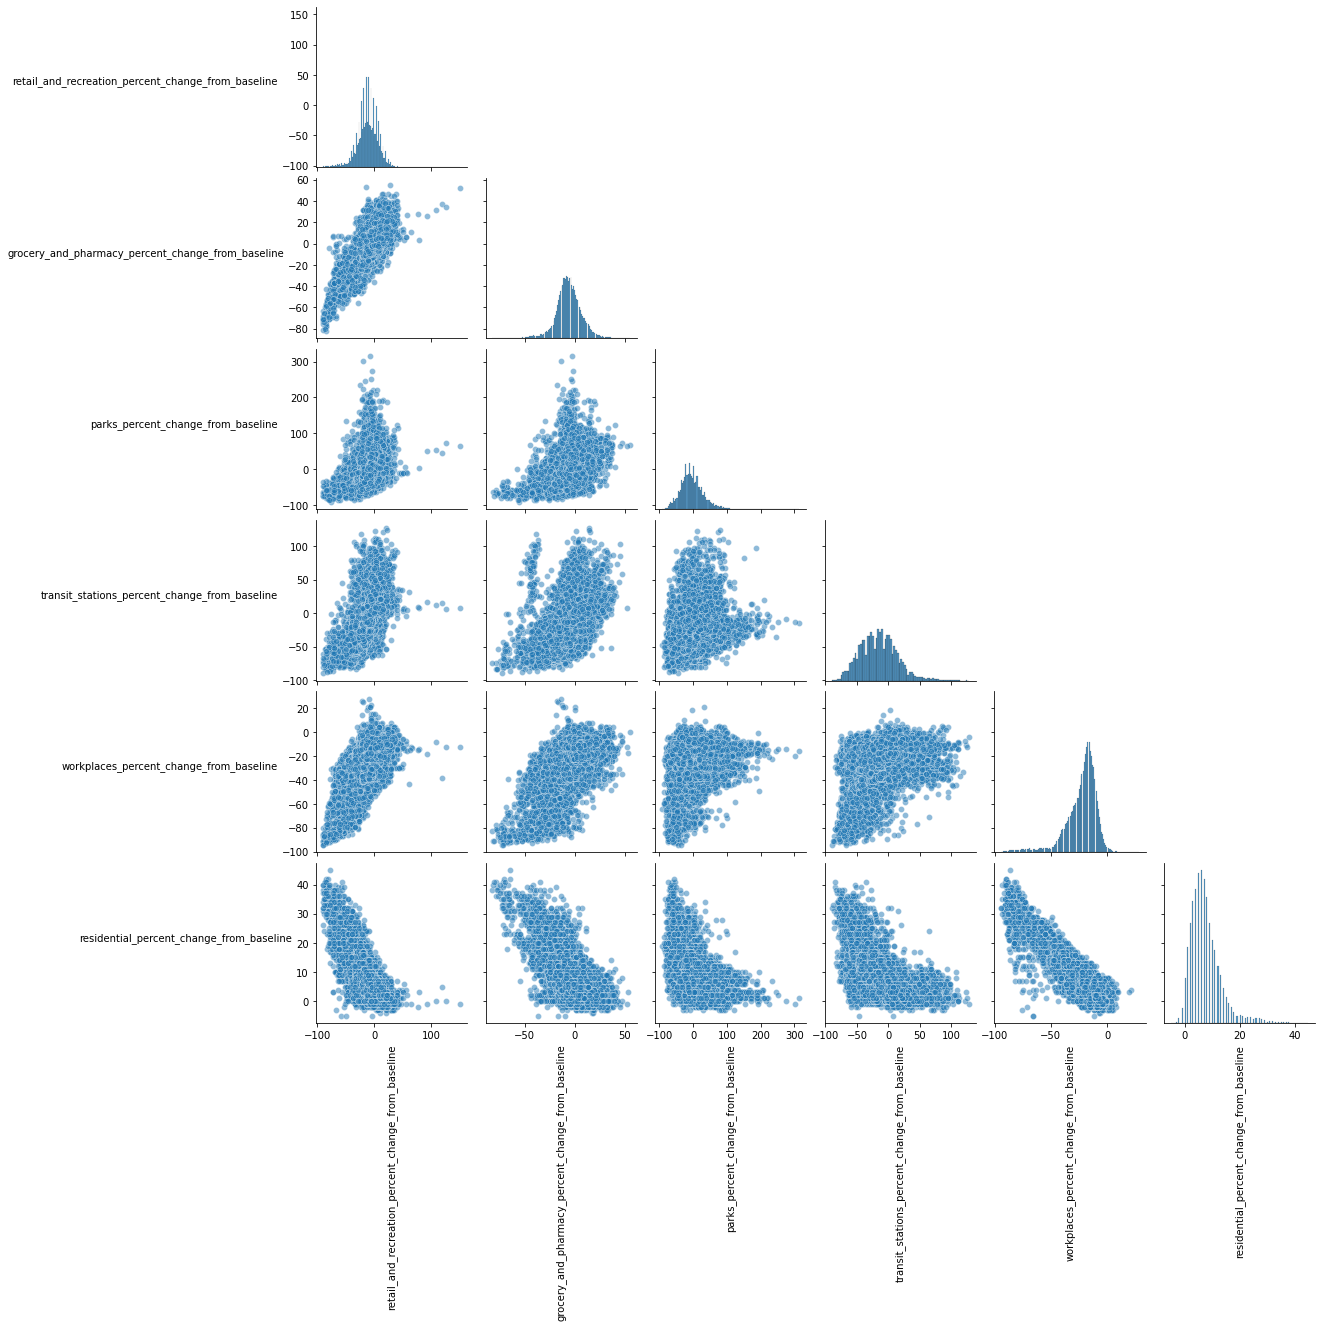

In [ ]:
fig = sns.pairplot(high_vs_low_2021[
    ["date", 
     "retail_and_recreation_percent_change_from_baseline", 
     "grocery_and_pharmacy_percent_change_from_baseline", 
     "parks_percent_change_from_baseline", 
     "transit_stations_percent_change_from_baseline", 
     "workplaces_percent_change_from_baseline", 
     "residential_percent_change_from_baseline"]], plot_kws=dict(marker="o", alpha = 0.5))
for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)
for ax in fig.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')
plt.show()

In [ ]:
#Defining the columns that are confounding variables
x_cols = ['cases_avg', 'deaths_avg']

In [ ]:
#Creating our 
Z = np.array(causal_data['treatment'])
Yi = np.array(causal_data['retail_and_recreation_percent_change_from_baseline'])
X = causal_data[x_cols].to_numpy()

In [ ]:
from sklearn.linear_model import LogisticRegression as LR 
lr = LR(penalty='none', max_iter=200, random_state=0)
lr.fit(X, Z)

LogisticRegression(max_iter=200, penalty='none', random_state=0)

Using the Inverse propensity Weighting estimate,


$\hat{\tau}$ = $\frac{1}{n}\sum_{i = 0}^{n} \frac{z_i y_i}{\hat{e}(x_i)} − \frac{(1−z_i) y_i}{1−\hat{e}(x_i)}$ 

In [ ]:
def estimate_treatment_effect(lr, X, Y, Z):
    tau = 1/len(Y)
    predicted_prob = lr.predict_proba(X)
    summ = 0
    for i in np.arange(len(Y)):
        summ += (Z[i] * Y[i])/predicted_prob[i][1] - ((1-Z[i]) * Y[i])/(predicted_prob[i][0])
    return tau * summ

estimate = estimate_treatment_effect(lr, X, Yi, Z)
print(estimate)

5.841330748465346


In [ ]:
def naive_estimate_treatment_effect(lr, Y, Z):
    n = len(Y)
    n1 = np.sum(Z)
    return (1/n1) * np.sum(Y * Z) - (1/(n-n1)) * np.sum(Y * (1-Z))
estimate = naive_estimate_treatment_effect(lr, Yi, Z)
print(estimate)

6.172571166605492


In [ ]:
def bootstrap_1d(samples, B=1000, fnc=np.mean):
    theta_boot = np.zeros(shape=(B,))
    for b in range(B):
        bootstrap_samples = rnd.choice(samples, N)
        theta_boot[b] = fnc(bootstrap_samples)
        
    return theta_boot

Summarize and interpret your results, providing a clear statement about causality (or a lack thereof) including any assumptions necessary.
- Since this estimate of the treatment effect is positive, it indicates that the having low covid restrictions and no mask mandates improves the recreation and retail percent change from average compared to those with high covid restrictions. This means that states that have low covid restrictions have a higher percentage of people visiting stores and frequenting recreational activies than those that have high covid restrictions. The increase in the naive estimator indicates that our confounders are actually confounders and have an impact on the outcome. 

Where possible, discuss the uncertainty in your estimate and/or the evidence against the hypotheses you are investigating.
- DO BOOTSTRAP OKAY

Did your data exhibit Simpson’s paradox?
Elaborate on the limitations of your methods.

What additional data would be useful for answering this causal question, and why?
- Some confounders that we cannot account for, given the lack of data on the subject, is the vaccine availabilty. If we have this information, we might be able to answer more questions, and have more information about maybe why the retail and recreation numbers are higher, or why these specific states have low restrictions. Maybe the amount of people who are vaccinated also impacts the number of people who frequent the shops!

How confident are you that there’s a causal relationship between your chosen treatment and outcome? Why?
- We are fairly confident that there is a causal relationship between our chosen treament and outcome. In the early stages of the pandemic especially, when the covid restrictions were high among almost all of the states, the percent change from these baselines was fairly similar, as evident by the very beginning of the graphs of 2020-21 in section 2.2 and 2.3. However, as the states took their own decision with how lenient they would be with the restrictions (closure of shops, mask mandates, closure of public parks, or, on the other hand, no closure/mask mandate), the difference in states becomes more and more obvious. The states that have high covid restrictions tend to form a conglomorate that follows a similar trend of lower percent changes, while those with low covid restrictions have a percent change that is closer to the baseline. 

## 4.2 GLM - Question 2

Guiding Question: 

Describe what you’re trying to predict, and what features you’re using. Justify your
choices.
- We are trying to predict the percent change from baseline of retail and recreation after the release of the mask mandates. We are using -- features.

Describe the GLM you’ll be using, justifying your choice. Describe any assumptions being made by your modeling choice.
- We will be using a gaussian GLM. We are using this because (the other two predict counts?))))) -------. The assumptions we are making is that we are unlikely that we will see values more than 3$\sigma$ away from the mean. That means that we're implicitly assuming that the vast majority of $y$-values we see will be within 3$\sigma$ of the mean (i.e., the prediction $X\beta$).

Describe the nonparametric method you’ll be using, justifying your choice. Describe any assumptions being made by your modeling choice.
- The nonparametric method we will be using is ----------

How will you evaluate each model’s performance?
- We will evaluate the model's performance by -------------. 

In [ ]:
released_mask_mandate = c_regional_stats.loc[c_regional_stats['sub_region_1'].isin(states_released)]
has_mas_mandate = c_regional_stats.loc[~c_regional_stats['sub_region_1'].isin(states_released)]

pd.to_csv("released_mask_mandate.csv")


NameError: ignored

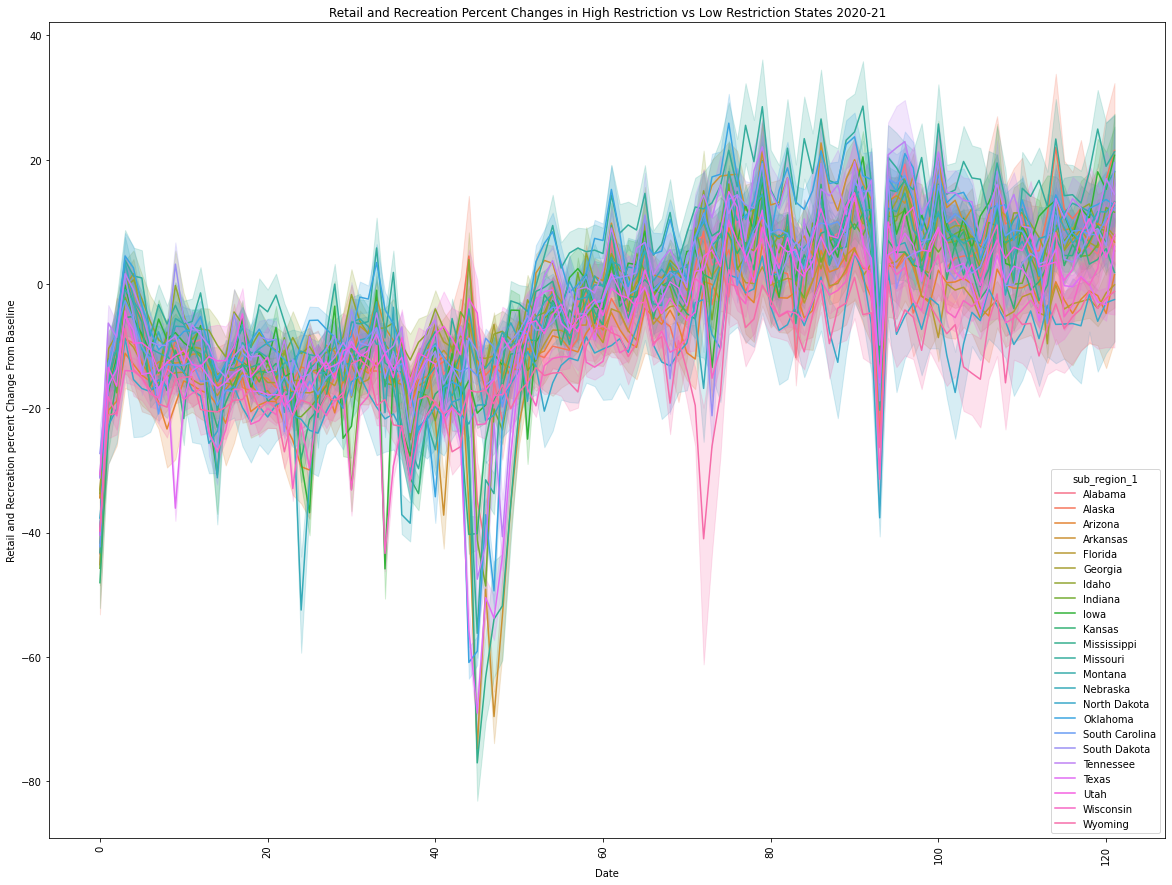

In [ ]:
sns.lineplot(x="ddate", y="retail_and_recreation_percent_change_from_baseline", hue="sub_region_1", data=released_mask_mandate)
plt.gcf().set_size_inches(20, 15)
plt.ylabel("Retail and Recreation percent Change From Baseline")
plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.title("Retail and Recreation Percent Changes in High Restriction vs Low Restriction States 2020-21")
plt.show();

In [ ]:
X = 'retail_and_recreation_percent_change_from_baseline'
y = 'ddate'

In [ ]:
#Gaussian model on the low-covid-restriction states (released the mask mandate already)
gaussian_model = sm.GLM(
    released_mask_mandate[X], sm.add_constant(released_mask_mandate[y]), 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     retail_and_recreation_percent_change_from_baseline   No. Observations:                96452
Model:                                                            GLM   Df Residuals:                    96450
Model Family:                                                Gaussian   Df Model:                            1
Link Function:                                               identity   Scale:                          202.81
Method:                                                          IRLS   Log-Likelihood:            -3.9305e+05
Date:                                                Sat, 08 May 2021   Deviance:                   1.9561e+07
Time:                                                        13:58:02   Pearson chi2:                 1.96e+07
No. Iterations:                                                     3                                         
C

In [ ]:
#Gaussian model on the high-covid-restriction states (still have a mask mandate in place)
gaussian_model = sm.GLM(
    has_mask_mandate[X], sm.add_constant(has_mask_mandate[y]), 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                                 Generalized Linear Model Regression Results                                  
Dep. Variable:     retail_and_recreation_percent_change_from_baseline   No. Observations:               107773
Model:                                                            GLM   Df Residuals:                   107771
Model Family:                                                Gaussian   Df Model:                            1
Link Function:                                               identity   Scale:                          194.53
Method:                                                          IRLS   Log-Likelihood:            -4.3694e+05
Date:                                                Sat, 08 May 2021   Deviance:                   2.0965e+07
Time:                                                        13:58:02   Pearson chi2:                 2.10e+07
No. Iterations:                                                     3                                         
C

In [ ]:
#Random Forest 
model = RandomForestClassifier(n_estimators=100, max_depth=6)
model.fit(released_mask_mandate[X].to_numpy().reshape(-1, 1), released_mask_mandate[y].to_numpy())
probs = model.predict_proba(released_mask_mandate[X].to_numpy().reshape(-1, 1))[:, 1]
predictions = probs > 0.5
print("Accuracy", (predictions == released_mask_mandate[y].to_numpy()).mean())

Accuracy 0.009331066229834529
